In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
img = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images/65019.jpg")
img_gt = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-gt/65019.png")

img_label = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-labels/65019-anno.png")


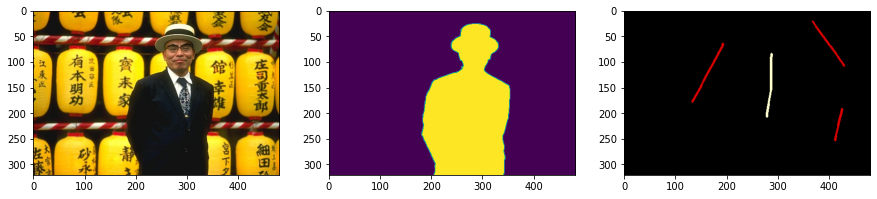

In [2]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131)
ax1.imshow(img)
ax2 = fig.add_subplot(132)
ax2.imshow(img_gt)
ax3 = fig.add_subplot(133)
ax3.imshow(img_label)

In [3]:
import networkx as nx
from math import *
G = nx.Graph()
nbx = 200
nby = 200
nodes = [str(i)+","+str(j) for i in range(nbx) for j in range(nby)]
G.add_nodes_from(nodes, terminal = None, parent = None)
G.add_weighted_edges_from([(str(i)+","+str(j),str(i+1)+","+str(j),exp(abs(i+j+2-nbx)*4/nbx)) for i in range(nbx-1) for j in range(nby)])
G.add_weighted_edges_from([(str(i)+","+str(j),str(i)+","+str(j+1),exp(abs(i+j+1-nbx)*4/nbx)) for i in range(nbx) for j in range(nby-1)])
nx.set_edge_attributes(G, 'black', "color")
# nx.draw_kamada_kawai(G, edge_color = nx.get_edge_attributes(G,'color').values(), width=3, with_labels=True, font_weight='bold')

In [4]:
def grow(Graph, Active):
    while len(Active)>0:
        node_name = Active.pop()
        node = Graph.nodes[node_name]
        terminal = node['terminal']
        if terminal != None:
            for neighbor_name in Graph[node_name]:
                neighbor = Graph.nodes[neighbor_name]
                if neighbor['terminal'] == None:
                    Active.insert(0,neighbor_name)
                    neighbor['terminal'] = terminal
                    neighbor['parent'] = node_name
                    Graph[node_name][neighbor_name]['color'] = (terminal=='S' and 'r') or 'b'
                if neighbor['terminal'] != terminal:
                    Active.append(node_name)
                    return(node_name,neighbor_name)
    return None

def get_path_flow(Graph, initial_node):
    max_flow = inf
    node_name = initial_node
    path = [node_name]
    node = Graph.nodes[node_name]
    while not node['parent'] in ['S','T']:
        parent_name = node['parent']
        parent = Graph.nodes[parent_name]
        max_flow = min(Graph[node_name][parent_name]['weight'],max_flow)
        path += [parent_name]
        node_name=parent_name
        node = parent
    return path,max_flow

def augment(Graph,path,max_flow):
    Orphans = []
    for i in range(len(path)-1):
        node = path[i]
        next_node = path[i+1]
        Graph[node][next_node]['weight'] -= max_flow
        if Graph[node][next_node]['weight'] == 0:
            Graph.remove_edge(node,next_node)
            terminal = Graph.nodes[node]['terminal']
            if terminal == Graph.nodes[next_node]['terminal']:
                if terminal == 'S':
                    Graph.nodes[next_node]['parent'] = None
                    Orphans += [next_node]
                else:
                    Graph.nodes[node]['parent'] = None
                    Orphans += [node]

    return Orphans

def root(Graph,node):
    current = node
    parent = Graph.nodes[node]['parent']
    while not parent in ['S','T',None]:
        current = parent
        parent =  Graph.nodes[current]['parent']
    return current, parent

def adopt(Graph,Orphans,Active):
    while len(Orphans) != 0:
        node_name = Orphans.pop()
        node = Graph.nodes[node_name]
        children = []
        for neighbor_name in Graph[node_name]:
            neighbor = Graph.nodes[neighbor_name]
            assert node['terminal']
            if node['terminal'] == neighbor['terminal']:
                if neighbor['parent'] == node_name:
                    children.append(neighbor_name)
                elif root(Graph, neighbor_name)[0] != node_name:
                    node['parent'] = neighbor_name
                    Graph[node_name][neighbor_name]['color'] = (node['terminal']=='S' and 'r') or 'b'
                    break
                Active.insert(0,neighbor_name)
        Active = list(filter(lambda n: n!=node_name, Active))
        if (node['parent'] == None):
            for child in children:
                Graph.nodes[child]['parent'] = None
                Graph[node_name][child]['color'] = 'black'
            Orphans += children
            node['terminal'] = None
    return

In [11]:
def max_cut_min_flow(Graph, S, T):
    for t in T:
        Graph.nodes[t]['terminal'] = 'T'
        Graph.nodes[t]['parent'] = 'T'
    for t in S:
        Graph.nodes[t]['terminal'] = 'S'
        Graph.nodes[t]['parent'] = 'S'
    active = S+T
    touching_nodes = grow(Graph,active)
    epoch = 0
    while touching_nodes:
        n1, n2 = touching_nodes
        path1, maxflow1 = get_path_flow(Graph,n1)
        path2, maxflow2 = get_path_flow(Graph,n2)
        if Graph.nodes[n1]['terminal'] == 'S':
            path = path1[::-1]+path2
        else:
            path = path2[::-1]+path1
        orphans = augment(Graph,path,min(maxflow1, maxflow2, Graph[n1][n2]['weight']))
        adopt(Graph,orphans,active)
        touching_nodes = grow(Graph,active)
        epoch+=1
        if epoch%10 == 0: print(epoch)

    return(Graph)

graph = G.copy()
graph = max_cut_min_flow(graph,['20,20','10,10'],['180,180'])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


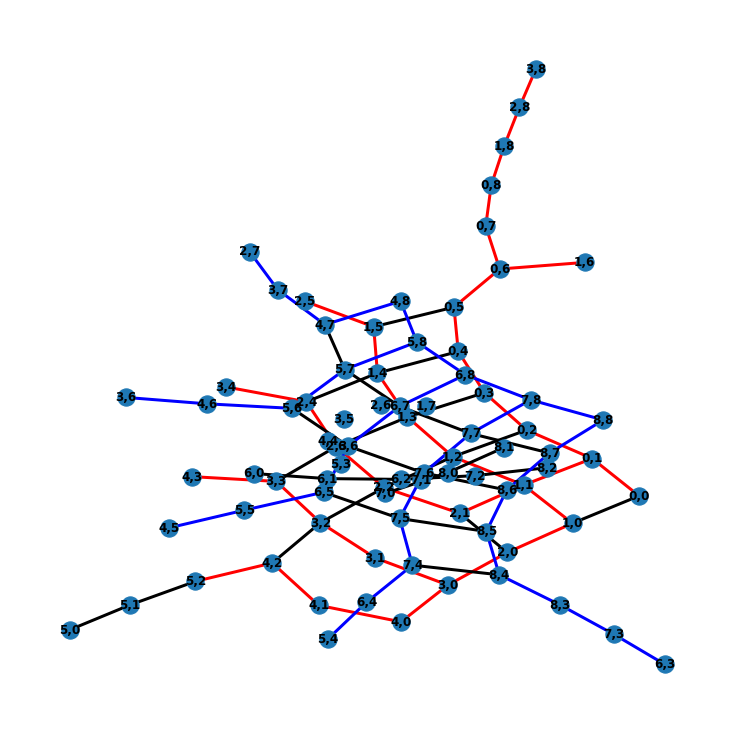

In [7]:
fig = plt.figure(figsize=(10,10))
G_draw = graphs[-1].copy()
nx.set_edge_attributes(G_draw, 1, "weight")
nx.draw_kamada_kawai(G_draw, edge_color = nx.get_edge_attributes(G_draw,'color').values(), width=3, with_labels=True, font_weight='bold')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] 0.9974


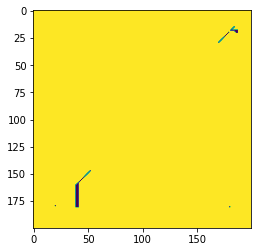

In [12]:
def get_cut(G,width,height):
    segmentation = np.zeros((width,height))
    for x in range(width):
        for y in range(height):
            if graph.nodes[str(x)+','+str(y)]['terminal'] == 'S':
                segmentation[x,y] = 1
    return segmentation

def dice_score(seg_1, seg_2):
    n1 = len(seg_1.flatten())
    n2 = len(seg_2.flatten())
    assert n1 == n2
    unique, count = np.unique(seg_1[seg_1==seg_2], return_counts=True)
    intersection_nb = count[list(unique).index(1)]
    return 2*intersection_nb/(n1+n2)


seg = get_cut(graph, nbx, nby)
print(seg, dice_score(np.ones((nbx,nby)),seg))
plt.imshow(seg)

In [13]:
def dinic_path_search(Graph, S):
    active = S
    while len(active)>0:
        node_name = active.pop()
        node = Graph.nodes[node_name]
        for neighbor_name in Graph[node_name]:
            neighbor = Graph.nodes[neighbor_name]
            if neighbor['parent'] == None:
                neighbor['parent'] = node_name
                active += [neighbor_name]
            elif neighbor['parent'] == 'T':
                tree_path, flow = get_path_flow(Graph,node_name)
                min_flow = min(Graph[node_name][neighbor_name]['weight'],flow)
                path = [neighbor_name]+tree_path
                dinic_augment(Graph, path, min_flow)
                return False
    return True

def dinic_augment(Graph, path, max_flow):
    for i in range(len(path)-1):
        Graph[path[i]][path[i+1]]['weight'] -= max_flow
        if Graph[path[i]][path[i+1]] == 0:
            Graph.remove_edge(path[i],path[i+1])

        

In [14]:
def dinic(Graph,S,T):
    for t in T:
        Graph.nodes[t]['parent'] = 'T'
    for t in S:
        Graph.nodes[t]['parent'] = 'S'
    is_cut = False
    epoch = 0
    while not is_cut:
        epoch += 1
        is_cut = dinic_path_search(Graph, S)
        if epoch%10 == 0: print(epoch)
    return Graph

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] 0.9974


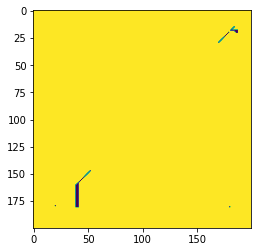

In [15]:
dinic_cut = dinic(G.copy(),['20,20','10,10'],['180,180'])
dinic_seg = get_cut(dinic_cut, nbx, nby)
print(dinic_seg, dice_score(np.ones((nbx,nby)),dinic_seg))
plt.imshow(dinic_seg)